# Doc2Vec with K-Means
## Reading data from CSV

In [1]:
import pandas as pd
from gensim.models.doc2vec import TaggedDocument
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import numpy as np

from src.commons.parse_utils import parse_list_column

In [2]:
csv_file = "../../data/arxiv_processed.csv"
data = pd.read_csv(csv_file, sep=";", converters={'Processed Summary': parse_list_column})

In [3]:
data.head()

,ID,Title,Summary,Published,PDF Link,Processed Summary
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,"[revisit, issue, connection, two, leading, for..."
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,"[randomized, algorithm, deciding, satisfiabili..."
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,"[two, different, type, agency, discussed, base..."
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,"[paper, present, method, computing, revision, ..."
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,"[diagnostic, reasoning, characterized, logical..."


## Training Doc2Vec model

In [4]:
from gensim.models import Doc2Vec

tagged_data = [TaggedDocument(words=row['Processed Summary'], tags=[str(index)]) for index, row in data.iterrows()]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

## Clustering with K-Means

In [5]:
kmeans = KMeans(n_clusters=35, init='k-means++', max_iter=300, n_init=10, random_state=0)

In [6]:
y_kmeans = kmeans.fit_predict(model.dv.vectors)

In [7]:
data['Topic'] = y_kmeans

In [8]:
data.head()

,ID,Title,Summary,Published,PDF Link,Processed Summary,Topic
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,"[revisit, issue, connection, two, leading, for...",32
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,"[randomized, algorithm, deciding, satisfiabili...",32
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,"[two, different, type, agency, discussed, base...",11
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,"[paper, present, method, computing, revision, ...",32
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,"[diagnostic, reasoning, characterized, logical...",7


### Visualizing clusters

In [9]:
X_embedded = TSNE(n_components=2).fit_transform(model.dv.vectors)

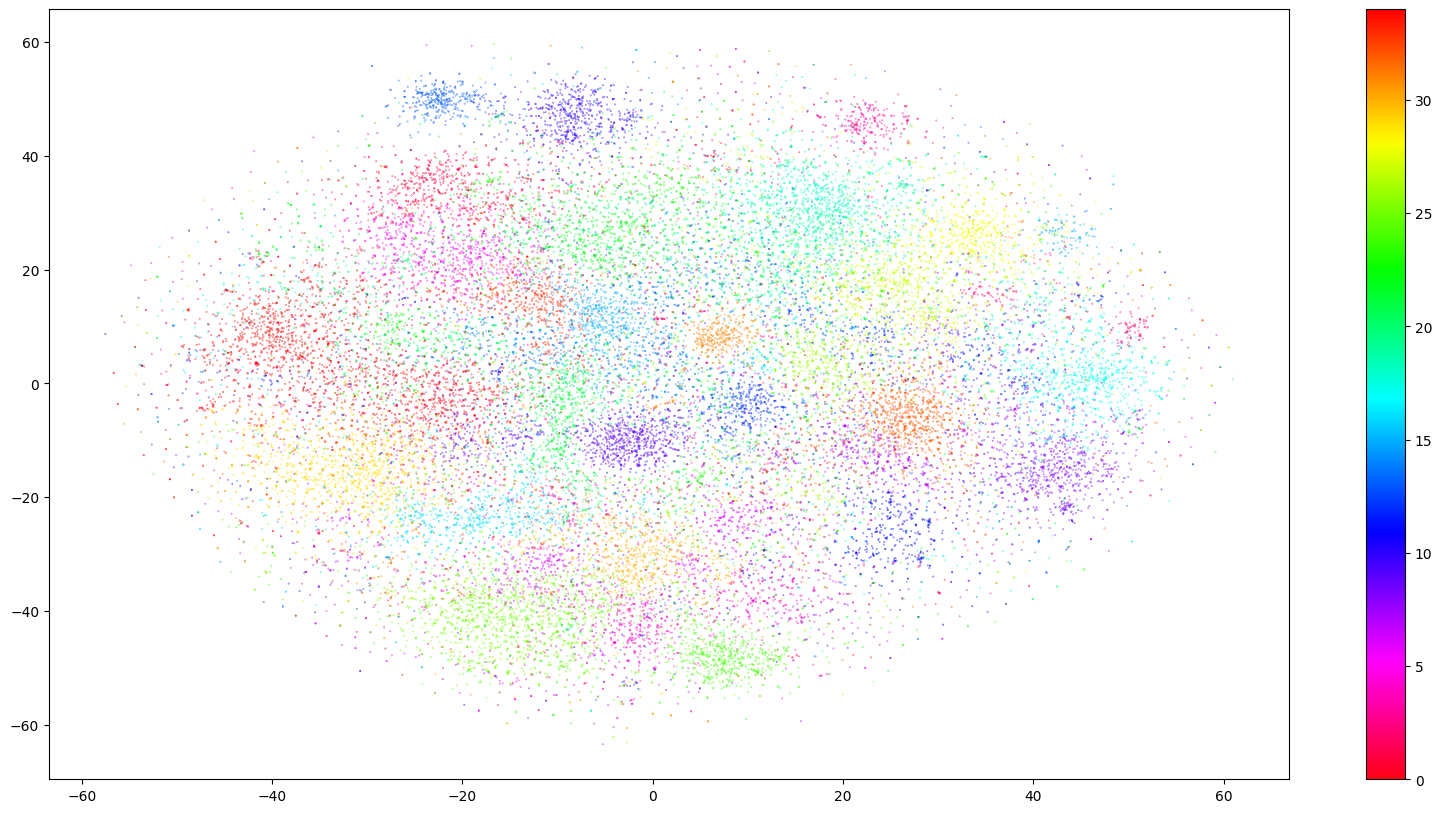

In [10]:
plt.figure(figsize=(20, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_kmeans, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

#### Topic 0 exploration
##### Visualization

In [11]:
topic1_embedded = X_embedded[y_kmeans == 0]

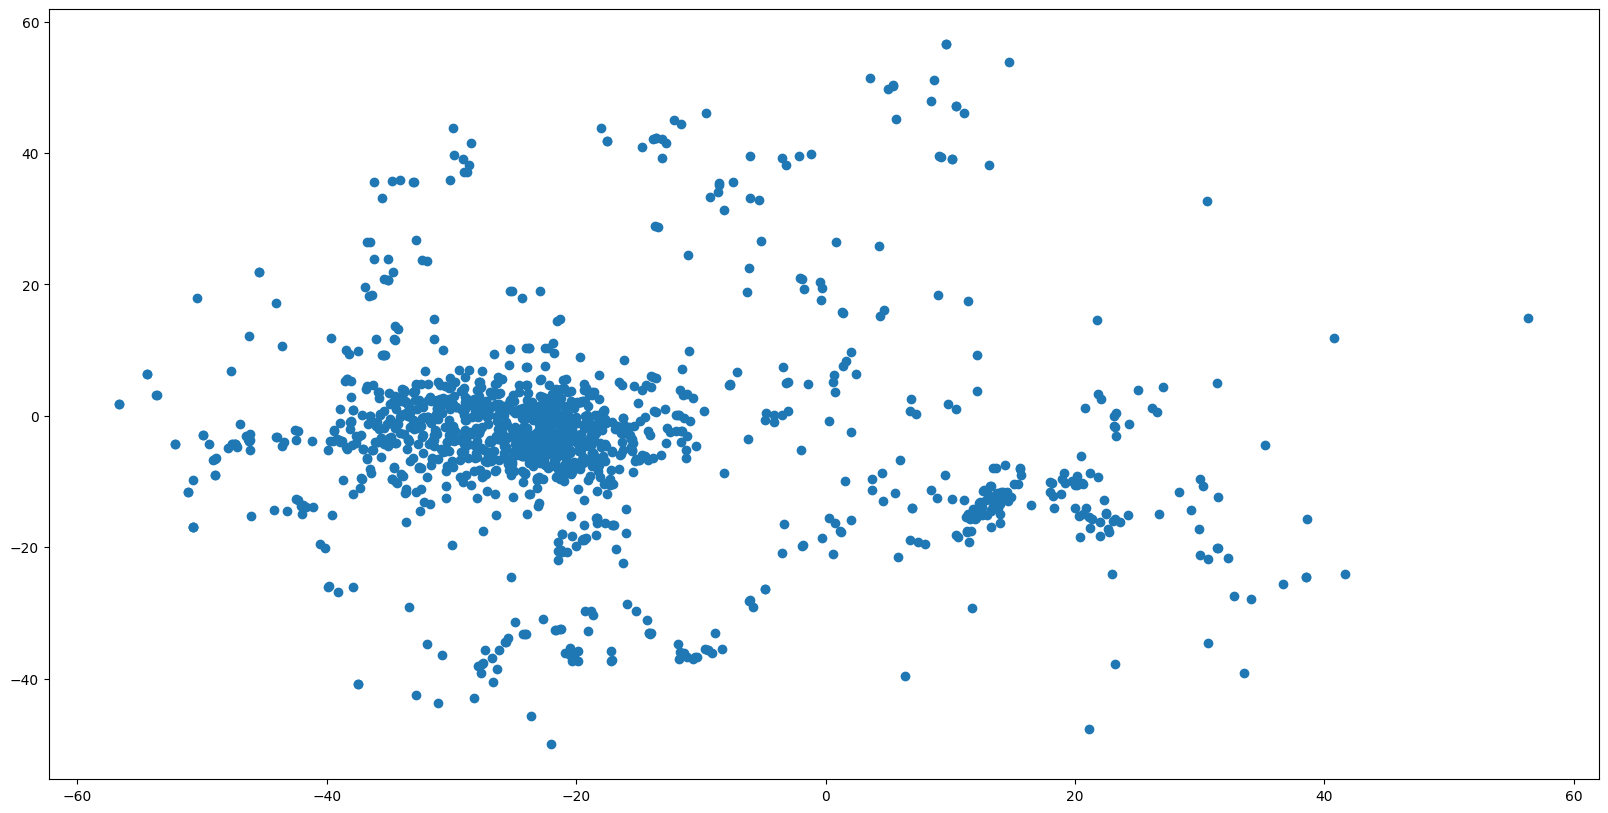

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(topic1_embedded[:, 0], topic1_embedded[:, 1])
plt.show()

##### Words

In [13]:
processed_summaries = []
for summary in data['Processed Summary']:
    processed_summaries.append(' '.join(summary))

docs_df = pd.DataFrame(processed_summaries, columns=["Doc"])
docs_df['Topic'] = y_kmeans
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [14]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [15]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [16]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
25,25,1692
29,29,1467
0,0,1414
14,14,1321
22,22,1276
32,32,1238
27,27,1231
19,19,1228
26,26,1168
34,34,1144


In [17]:
# topic 0 size
topic_sizes[topic_sizes['Topic'] == 0]

,Topic,Size
0,0,1414


In [18]:
top10_words_topic0 =  [i[0] for i in  top_n_words[0][:10]]
print(top10_words_topic0)

['bayesian', 'inference', 'variable', 'distribution', 'probabilistic', 'function', 'causal', 'neural', 'probability', 'network']


Some 10 examples summaries from cluster 0:

In [19]:
topic0_docs = data[data['Topic'] == 0]

In [20]:
for index, row in topic0_docs.head(10).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Topic: {row['Topic']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/cs/0405032v1
Title: EvoNF: A Framework for Optimization of Fuzzy Inference Systems Using   Neural Network Learning and Evolutionary Computation
Summary: Several adaptation techniques have been investigated to optimize fuzzy inference systems. Neural network learning algorithms have been used to determine the parameters of fuzzy inference system. Such models are often called as integrated neuro-fuzzy models. In an integrated neuro-fuzzy model there is no guarantee that the neural network learning algorithm converges and the tuning of fuzzy inference system will be successful. Success of evolutionary search procedures for optimization of fuzzy inference system is well proven and established in many application areas. In this paper, we will explore how the optimization of fuzzy inference systems could be further improved using a meta-heuristic approach combining neural network learning and evolutionary computation. The proposed technique could be consider

In [21]:
top10_words_topic10 = [i[0] for i in  top_n_words[10][:10]]
print(top10_words_topic10)

['attack', 'adversarial', 'defense', 'security', 'backdoor', 'robustness', 'attacker', 'threat', 'perturbation', 'detection']


In [22]:
topic10_docs = data[data['Topic'] == 10]

In [23]:
for index, row in topic10_docs.head(10).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Topic: {row['Topic']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/1005.4496v1
Title: Combining Naive Bayes and Decision Tree for Adaptive Intrusion Detection
Summary: In this paper, a new learning algorithm for adaptive network intrusion detection using naive Bayesian classifier and decision tree is presented, which performs balance detections and keeps false positives at acceptable level for different types of network attacks, and eliminates redundant attributes as well as contradictory examples from training data that make the detection model complex. The proposed algorithm also addresses some difficulties of data mining such as handling continuous attribute, dealing with missing attribute values, and reducing noise in training data. Due to the large volumes of security audit data as well as the complex and dynamic properties of intrusion behaviours, several data miningbased intrusion detection techniques have been applied to network-based traffic data and host-based data in the last decades. However, there remain 

In [24]:
for i in range(35):
    print(f"Topic {i} size: {topic_sizes[topic_sizes['Topic'] == i]['Size'].values[0]}")
    print(f"Top 10 words: {[i[0] for i in  top_n_words[i][:10]]}")

Topic 0 size: 1414
Top 10 words: ['bayesian', 'inference', 'variable', 'distribution', 'probabilistic', 'function', 'causal', 'neural', 'probability', 'network']
Topic 1 size: 848
Top 10 words: ['image', 'diffusion', 'generation', '3d', 'style', 'generative', 'face', 'motion', 'video', 'scene']
Topic 2 size: 392
Top 10 words: ['student', 'education', 'teacher', 'course', 'educational', 'teaching', 'ai', 'learner', 'tool', 'chatgpt']
Topic 3 size: 497
Top 10 words: ['code', 'software', 'programming', 'program', 'developer', 'bug', 'llm', 'test', 'generation', 'language']
Topic 4 size: 983
Top 10 words: ['agent', 'environment', 'reinforcement', 'action', 'reward', 'policy', 'behavior', 'communication', 'goal', 'interaction']
Topic 5 size: 1112
Top 10 words: ['segmentation', 'object', '3d', 'image', 'detection', 'feature', 'point', 'map', 'module', 'depth']
Topic 6 size: 918
Top 10 words: ['planning', 'plan', 'action', 'planner', 'state', 'search', 'domain', 'policy', 'goal', 'reasoning']

### Topic Trend by year


In [25]:
data['Year'] = pd.to_datetime(data['Published']).dt.year

In [26]:
topic_trend = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')

In [27]:
topic_trend.head()

,Year,Topic,Count
0,2000,4,2
1,2000,6,2
2,2000,7,2
3,2000,11,2
4,2000,19,3


In [28]:
topic_trend_pivot = topic_trend.pivot(index='Year', columns='Topic', values='Count').fillna(0)

In [29]:
topic_trend_pivot.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,20.0,1.0,0.0
2001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,6.0,0.0,0.0,5.0,0.0,0.0,7.0,0.0,0.0
2002,2.0,0.0,0.0,1.0,3.0,2.0,2.0,5.0,0.0,0.0,...,2.0,2.0,0.0,0.0,2.0,1.0,0.0,32.0,0.0,1.0
2003,4.0,0.0,0.0,2.0,2.0,2.0,4.0,13.0,0.0,2.0,...,0.0,5.0,0.0,1.0,1.0,2.0,0.0,22.0,1.0,2.0
2004,5.0,0.0,0.0,1.0,0.0,2.0,1.0,9.0,0.0,3.0,...,1.0,1.0,2.0,0.0,13.0,2.0,3.0,13.0,4.0,1.0


Normalize it by number of articles in year

In [30]:
# Normalize topic_trend_pivot by number of articles in year
total_articles_per_year = topic_trend_pivot.sum(axis=1)

topic_trend_pivot_normalized = topic_trend_pivot.div(total_articles_per_year, axis=0)

topic_trend_pivot_normalized.head()

Topic,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.000000,0.0,0.0,0.000000,0.054054,0.000000,0.054054,0.054054,0.0,0.000000,...,0.000000,0.000000,0.027027,0.027027,0.027027,0.000000,0.000000,0.540541,0.027027,0.000000
2001,0.121212,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.030303,0.0,0.000000,...,0.030303,0.181818,0.000000,0.000000,0.151515,0.000000,0.000000,0.212121,0.000000,0.000000
2002,0.029412,0.0,0.0,0.014706,0.044118,0.029412,0.029412,0.073529,0.0,0.000000,...,0.029412,0.029412,0.000000,0.000000,0.029412,0.014706,0.000000,0.470588,0.000000,0.014706
2003,0.051282,0.0,0.0,0.025641,0.025641,0.025641,0.051282,0.166667,0.0,0.025641,...,0.000000,0.064103,0.000000,0.012821,0.012821,0.025641,0.000000,0.282051,0.012821,0.025641
2004,0.048544,0.0,0.0,0.009709,0.000000,0.019417,0.009709,0.087379,0.0,0.029126,...,0.009709,0.009709,0.019417,0.000000,0.126214,0.019417,0.029126,0.126214,0.038835,0.009709


<Axes: xlabel='Year'>

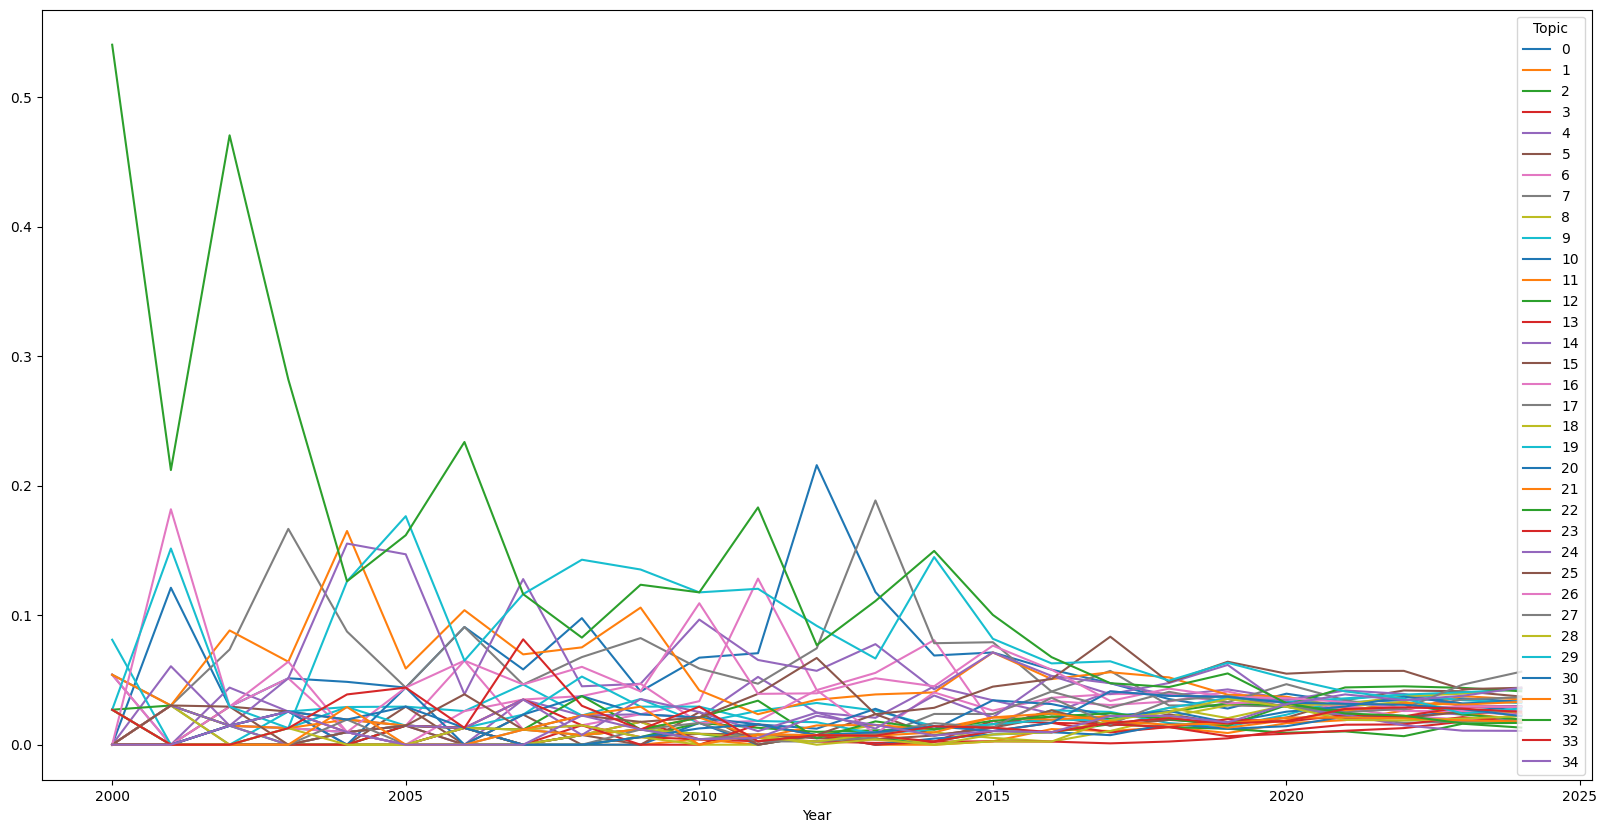

In [31]:
topic_trend_pivot_normalized.plot(kind='line', figsize=(20, 10))

<Axes: xlabel='Year'>

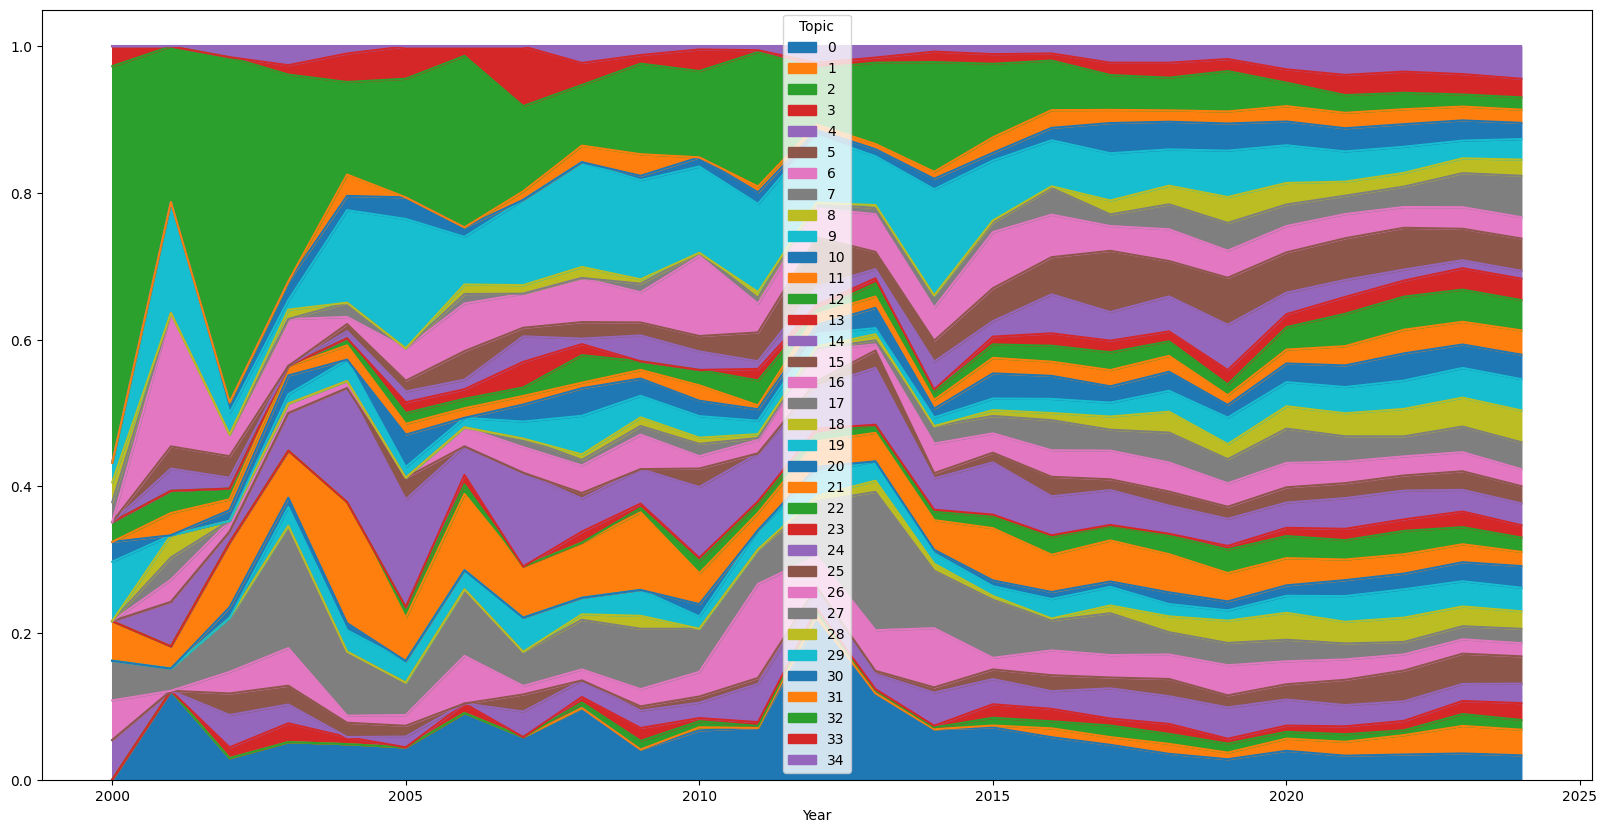

In [32]:
topic_trend_pivot_normalized.plot(kind='area', figsize=(20, 10))

<Axes: xlabel='Year'>

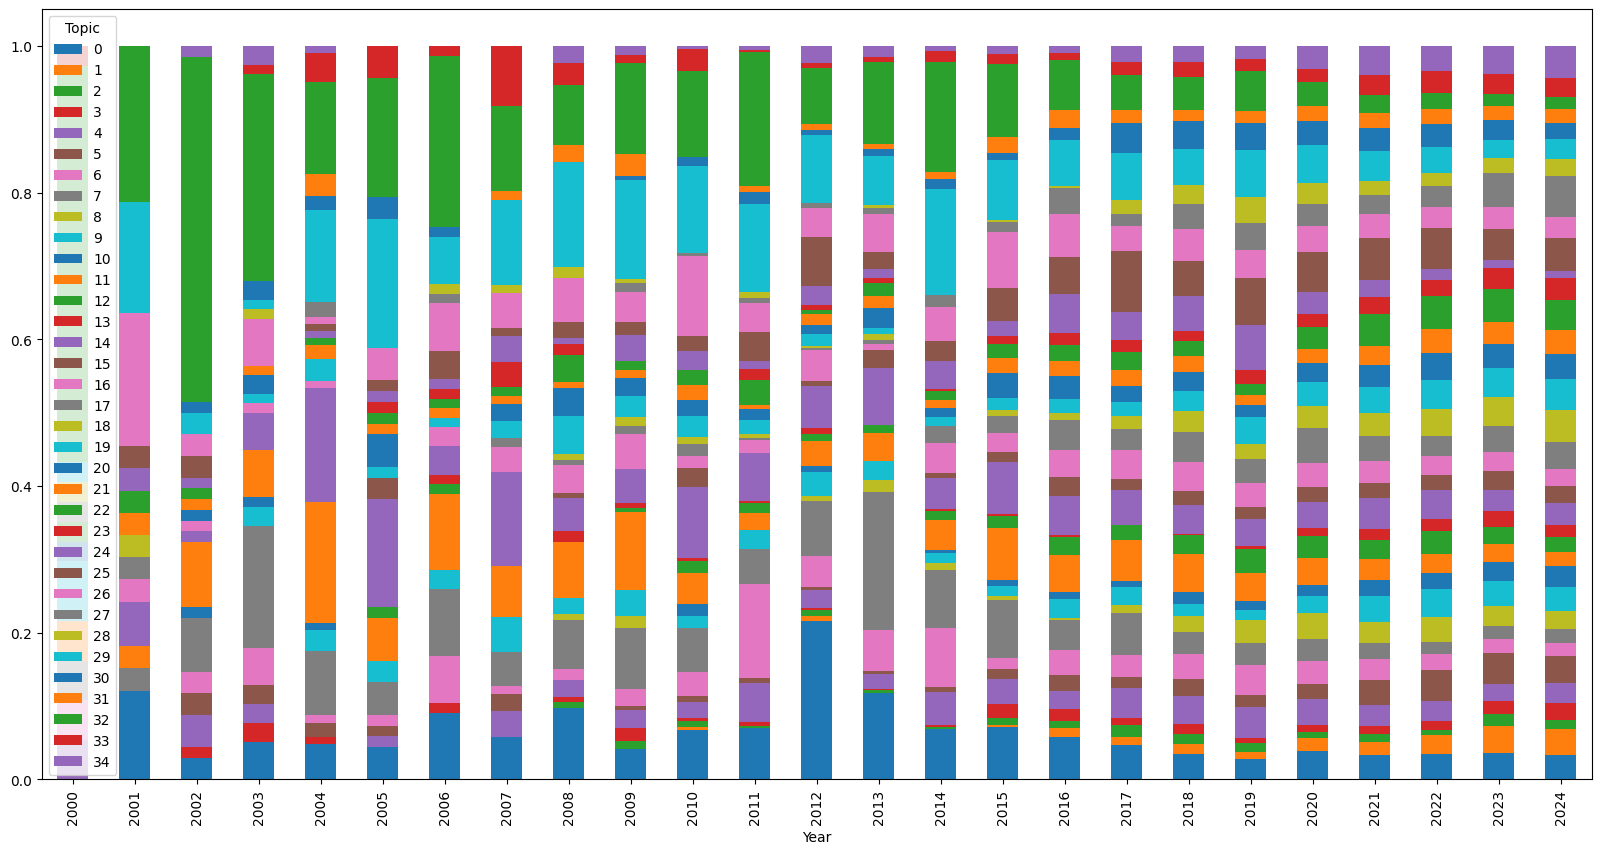

In [33]:
topic_trend_pivot_normalized.plot(kind='bar', stacked=True, figsize=(20, 10))

<Axes: xlabel='Year'>

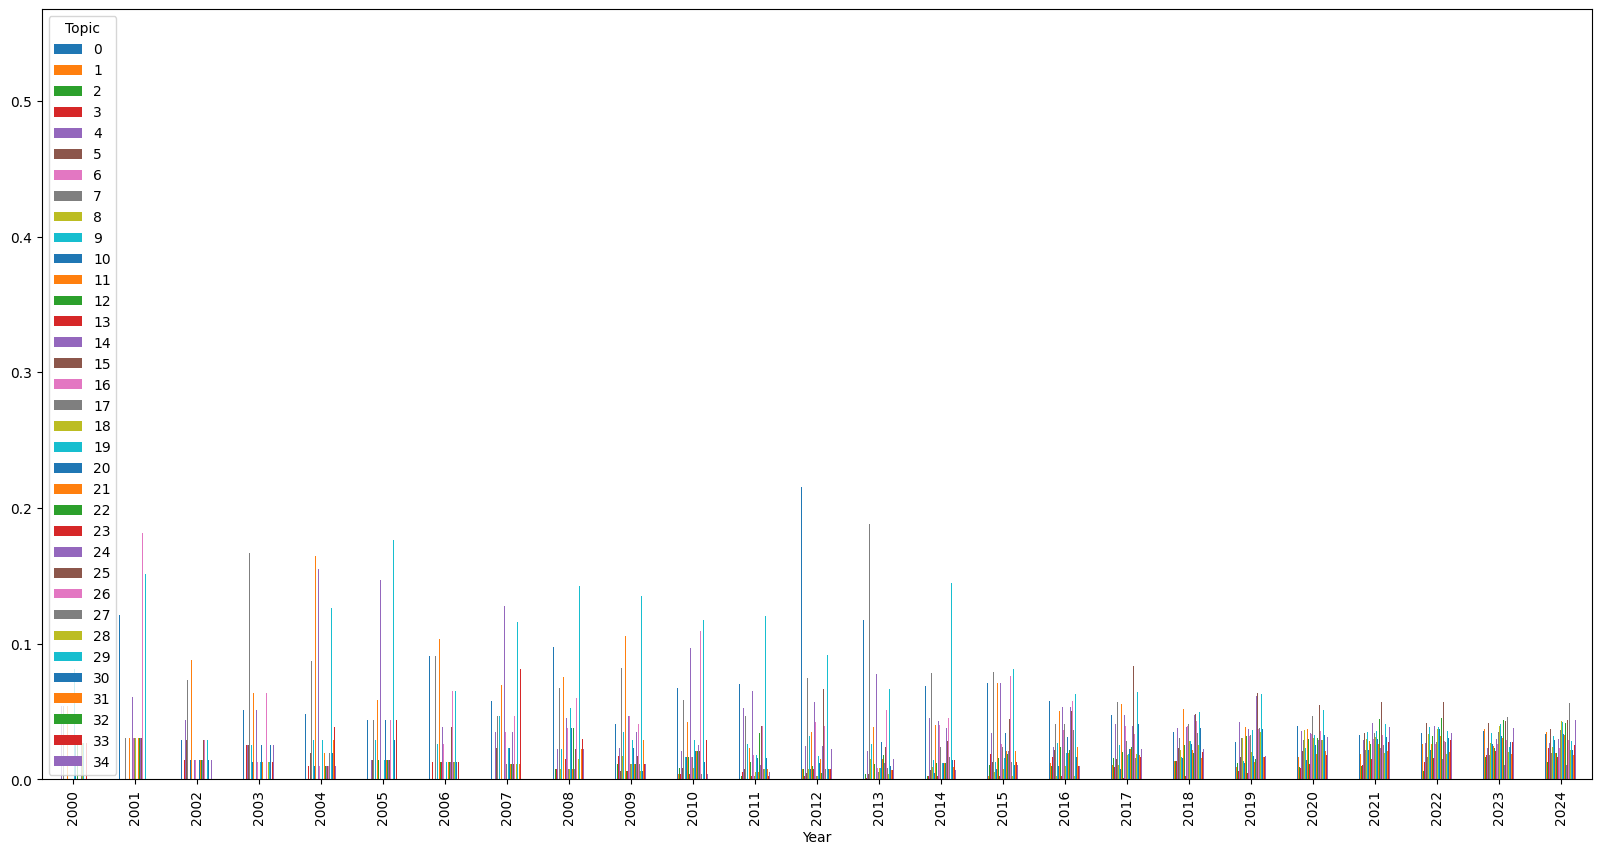

In [34]:
topic_trend_pivot_normalized.plot(kind='bar', figsize=(20, 10))

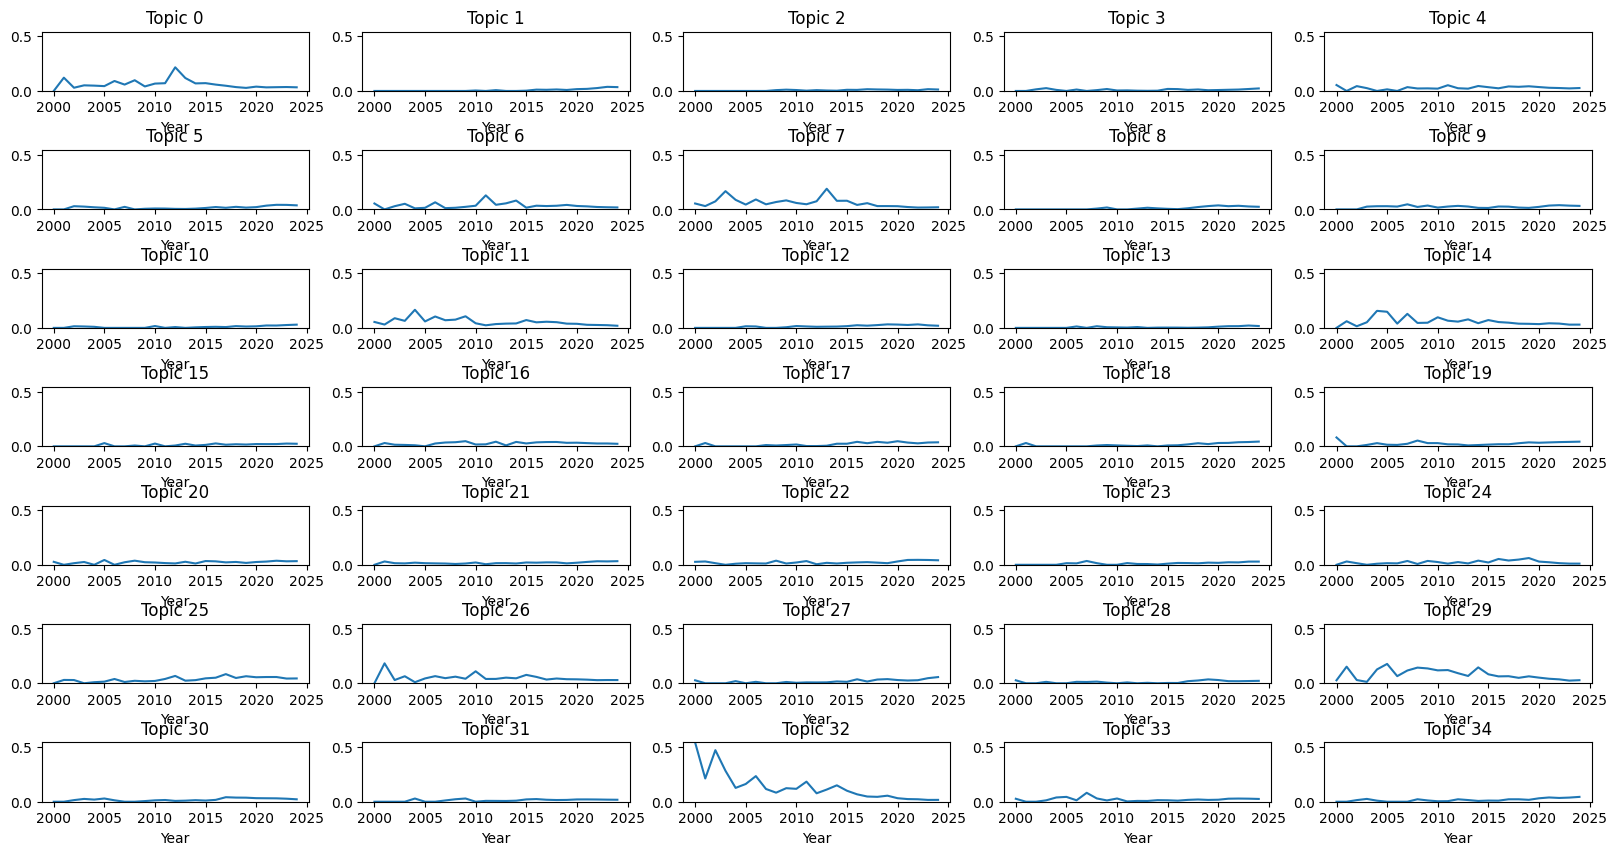

In [35]:
y_min = topic_trend_pivot_normalized.min().min()
y_max = topic_trend_pivot_normalized.max().max()

fig, axs = plt.subplots(7, 5, figsize=(20, 10))
for i in range(35):
    topic_trend_pivot_normalized[i].plot(ax=axs[i//5, i%5], title=f"Topic {i}")
    axs[i//5, i%5].set_ylim(y_min, y_max)  # Set the same y-axis limits for each subplot

plt.subplots_adjust(hspace=1)  # Adjust the height space between rows
plt.show()

### Metrics

In [27]:
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity, InvertedRBO
from octis.evaluation_metrics.similarity_metrics import PairwiseJaccardSimilarity
from octis.evaluation_metrics.topic_significance_metrics import KL_uniform, KL_vacuous, KL_background

In [22]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words_list = [top_n_words[i] for i in range(len(top_n_words))]
top_n_words_list = [[tuple[0] for tuple in topic] for topic in top_n_words_list]
top_n_words_list

[['cognitive',
  'intelligence',
  'human',
  'brain',
  'artificial',
  'theory',
  'machine',
  'concept',
  'computational',
  'ai',
  'neural',
  'consciousness',
  'cognition',
  'ability',
  'biological',
  'intelligent',
  'world',
  'computer',
  'memory',
  'mechanism',
  'reasoning',
  'computing',
  'processing',
  'architecture',
  'understanding',
  'symbolic',
  'neuron',
  'structure',
  'evolution',
  'general'],
 ['vehicle',
  'traffic',
  'service',
  'control',
  'scheduling',
  'management',
  'resource',
  'energy',
  'routing',
  'demand',
  'solution',
  'network',
  'transportation',
  'simulation',
  'optimization',
  'time',
  'communication',
  'dynamic',
  'cost',
  'optimal',
  'reinforcement',
  'route',
  'environment',
  'operation',
  'road',
  'algorithm',
  'urban',
  'device',
  'smart',
  'power'],
 ['pruning',
  'architecture',
  'quantization',
  'memory',
  'parameter',
  'layer',
  'neural',
  'training',
  'accuracy',
  'network',
  'weight',
 

In [34]:
# calculate probability that document belongs to topic
centroids = kmeans.cluster_centers_
doc_embeddings = model.dv.vectors

In [35]:
from scipy.spatial.distance import cdist

distances = cdist(doc_embeddings, centroids, 'euclidean')
distances.shape

(34427, 35)

In [36]:
beta = 1.0
weights = np.exp(-beta * distances.T)
weights /= weights.sum(axis=0)

print("N x D Weights Matrix:")
print(weights)

N x D Weights Matrix:
[[0.03709201 0.02542859 0.05122558 ... 0.02384894 0.01693581 0.02119294]
 [0.0168009  0.02543819 0.03144763 ... 0.01885514 0.03281076 0.01874805]
 [0.02286068 0.02692566 0.03023985 ... 0.02667353 0.02741977 0.03594149]
 ...
 [0.01620563 0.02178477 0.01887679 ... 0.01966811 0.03070559 0.10190948]
 [0.01932747 0.01854288 0.01950319 ... 0.018374   0.03085618 0.03280102]
 [0.01899943 0.01881252 0.03510596 ... 0.0271902  0.02565787 0.02075257]]


In [39]:
model_output = dict()
model_output['topics'] = top_n_words_list
model_output['topic-word-matrix'] = tf_idf
model_output["topic-document-matrix"] = weights

In [23]:
from octis.dataset.dataset import Dataset

dataset = Dataset()
dataset.load_custom_dataset_from_folder("../../data/octis")

In [30]:
def calculate_metrics(model_output, dataset, topk=10, verbose=False):
    umass = Coherence(texts=dataset.get_corpus(), topk=topk, measure='u_mass')
    npmi = Coherence(texts=dataset.get_corpus(), topk=topk, measure='c_npmi')
    c_v = Coherence(texts=dataset.get_corpus(), topk=topk, measure='c_v')
    topic_diversity = TopicDiversity(topk=topk)
    inv_rbo = InvertedRBO(topk=topk)
    pairwise_jaccard = PairwiseJaccardSimilarity()
    kl_uniform = KL_uniform()
    kl_vacuous = KL_vacuous()
    kl_background = KL_background()
    metrics = [(umass, 'UMass'), (npmi, 'NPMI'), (c_v, 'C_V'), (topic_diversity, 'Topic Diversity'), (inv_rbo, 'Inverted RBO'), (pairwise_jaccard, 'Pairwise Jaccard'), (kl_uniform, 'KL Uniform'), (kl_vacuous, 'KL Vacuous'), (kl_background, 'KL Background')]
    results = dict()
    for metric, name in metrics:
        try:
            metric_score = metric.score(model_output)
        except:
            metric_score = None
        finally:
            if verbose:
                print(f"{name}: {metric_score}")
            results[name] = metric_score
    return results


In [40]:
metrics = calculate_metrics(model_output, dataset, verbose=True)

UMass: -2.1131777616836716
NPMI: 0.13781809652979066
C_V: 0.6912939261181982
Topic Diversity: 0.7314285714285714
Inverted RBO: 0.9858515674127731
Pairwise Jaccard: 0.011876928273889522
KL Uniform: 2.8718009898330283
KL Vacuous: 9.261963992200151
KL Background: 0.03844930283161817
